This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-03-25 01:23:12--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.49.190, 54.231.134.136, 52.217.46.142, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.49.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.5MB/s    in 0.7s    

2023-03-25 01:23:13 (19.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

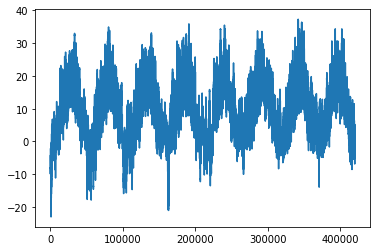

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature);

**Plotting the first 10 days of the temperature timeseries**

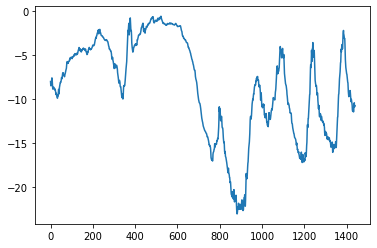

In [ ]:
plt.plot(range(1440), temperature[:1440]);

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 14ms/step - loss: 12.8427 - mae: 2.7750 - val_loss: 11.6535 - val_mae: 2.7047
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 9.1928 - mae: 2.3869 - val_loss: 12.2215 - val_mae: 2.7764
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 8.5530 - mae: 2.3043 - val_loss: 11.8003 - val_mae: 2.7204
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 8.0995 - mae: 2.2423 - val_loss: 11.1396 - val_mae: 2.6514
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 7.7912 - mae: 2.1975 - val_loss: 10.4363 - val_mae: 2.5639
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 7.5531 - mae: 2.1623 - val_loss: 11.6765 - val_mae: 2.7151
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 7.3556 - mae: 2.1352 - val_loss: 15.4775 - val_mae: 3.1352
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

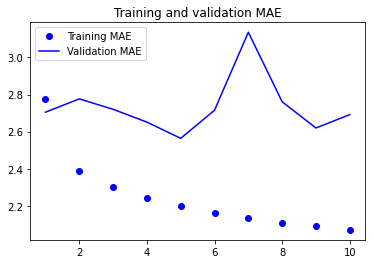

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show();

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 14ms/step - loss: 22.2985 - mae: 3.6826 - val_loss: 20.7720 - val_mae: 3.5772
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 15.4774 - mae: 3.1153 - val_loss: 15.0752 - val_mae: 3.0571
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 14.3010 - mae: 2.9894 - val_loss: 19.7164 - val_mae: 3.5552
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 13.5426 - mae: 2.9109 - val_loss: 15.0361 - val_mae: 3.0276
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 12.9337 - mae: 2.8456 - val_loss: 15.1004 - val_mae: 3.0759
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 12.3718 - mae: 2.7817 - val_loss: 13.6735 - val_mae: 2.9047
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 11.9588 - mae: 2.7311 - val_loss: 14.8066 - val_mae: 3.0308
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 15ms/step - loss: 46.0738 - mae: 4.9663 - val_loss: 13.5565 - val_mae: 2.7875
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 11.5452 - mae: 2.6214 - val_loss: 9.8424 - val_mae: 2.4413
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 10.0914 - mae: 2.4720 - val_loss: 9.8614 - val_mae: 2.4444
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 9.6752 - mae: 2.4237 - val_loss: 9.7310 - val_mae: 2.4316
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 9.4162 - mae: 2.3911 - val_loss: 10.2767 - val_mae: 2.4760
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 9.1577 - mae: 2.3551 - val_loss: 10.0861 - val_mae: 2.4671
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 8.9587 - mae: 2.3265 - val_loss: 10.3130 - val_mae: 2.4797
Epoch 8/10
819/819 [==============================] - 1

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 246s 297ms/step - loss: 29.0705 - mae: 3.9736 - val_loss: 9.9933 - val_mae: 2.4603
Epoch 2/50
819/819 [==============================] - 243s 297ms/step - loss: 14.9717 - mae: 3.0042 - val_loss: 9.7208 - val_mae: 2.4264
Epoch 3/50
819/819 [==============================] - 244s 298ms/step - loss: 13.8223 - mae: 2.8813 - val_loss: 10.4863 - val_mae: 2.5314
Epoch 4/50
819/819 [==============================] - 244s 298ms/step - loss: 13.0841 - mae: 2.8026 - val_loss: 9.3853 - val_mae: 2.3976
Epoch 5/50
819/819 [==============================] - 244s 298ms/step - loss: 12.6410 - mae: 2.7519 - val_loss: 9.7924 - val_mae: 2.4460
Epoch 6/50
819/819 [==============================] - 242s 295ms/step - loss: 12.2974 - mae: 2.7170 - val_loss: 9.6855 - val_mae: 2.4309
Epoch 7/50
819/819 [==============================] - 241s 294ms/step - loss: 11.9704 - mae: 2.6837 - val_loss: 9.6859 - val_mae: 2.4317
Epoch 8/50
819/819 [====================

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load Iris dataset
data = load_iris()
X, y = data.data, data.target

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# MISSING LINE OF CODE


In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 463s 560ms/step - loss: 24.7439 - mae: 3.6768 - val_loss: 9.6565 - val_mae: 2.4004
Epoch 2/50
819/819 [==============================] - 459s 560ms/step - loss: 13.9844 - mae: 2.8995 - val_loss: 9.9073 - val_mae: 2.4551
Epoch 3/50
819/819 [==============================] - 456s 557ms/step - loss: 13.2499 - mae: 2.8232 - val_loss: 8.9401 - val_mae: 2.3163
Epoch 4/50
819/819 [==============================] - 458s 559ms/step - loss: 12.7001 - mae: 2.7632 - val_loss: 8.8562 - val_mae: 2.3239
Epoch 5/50
819/819 [==============================] - 458s 559ms/step - loss: 12.2399 - mae: 2.7166 - val_loss: 8.8270 - val_mae: 2.3160
Epoch 6/50
819/819 [==============================] - 458s 559ms/step - loss: 11.7996 - mae: 2.6674 - val_loss: 8.7375 - val_mae: 2.2941
Epoch 7/50
819/819 [==============================] - 457s 558ms/step - loss: 11.4353 - mae: 2.6258 - val_loss: 8.8389 - val_mae: 2.3101
Epoch 8/50
819/819 [=====================

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 26.6876 - mae: 3.6928 - val_loss: 10.6526 - val_mae: 2.5333
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.3332 - mae: 2.3780 - val_loss: 10.0785 - val_mae: 2.4770
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.5228 - mae: 2.2723 - val_loss: 9.8992 - val_mae: 2.4504
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 7.9976 - mae: 2.2046 - val_loss: 9.8065 - val_mae: 2.4372
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.5908 - mae: 2.1482 - val_loss: 9.9088 - val_mae: 2.4525
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.3073 - mae: 2.1055 - val_loss: 10.2238 - val_mae: 2.4805
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.0358 - mae: 2.0658 - val_loss: 10.0730 - val_mae: 2.4675
Epoch 8/10
819/819 [==============================] - 15s

### Going even further

## Summary